#ライブラリのインポート

In [0]:
#基本ライブラリ
import numpy as np
import pandas as pd

#図形描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

from matplotlib.pylab import rcParams

#統計ライブラリ
import pystan
import pickle

#シミュレーションデータ

In [0]:
#サンプルサイズ
N = 450

#乱数固定
np.random.seed(10)

#時間によって変化する広告効果
true_reg_coef = -np.log(np.arange(1,51))*2+10

#ランダムウォークする水準値
mu = np.cumsum(np.random.normal(loc=0, scale=0.5, size=N)) + 25

#状態方程式
x = mu + np.concatenate((np.repeat(0,200),true_reg_coef, np.repeat(0,200)))

#観測誤差
obs_error = np.random.normal(loc=0, scale=2, size=N)

#観測値（広告効果が入った売上データ）
sales_ad = x + obs_error

#説明変数（1なら広告あり）
dummy_ad = np.zeros(N)
dummy_ad[201:251] = 1

#データフレームで整理
data = pd.DataFrame(dict(sales_ad=sales_ad, dummy_ad=dummy_ad))

In [8]:
data.head()

,sales_ad,dummy_ad
0,22.834287,0.0
1,26.212849,0.0
2,25.638334,0.0
3,26.333011,0.0
4,25.669880,0.0


##図示

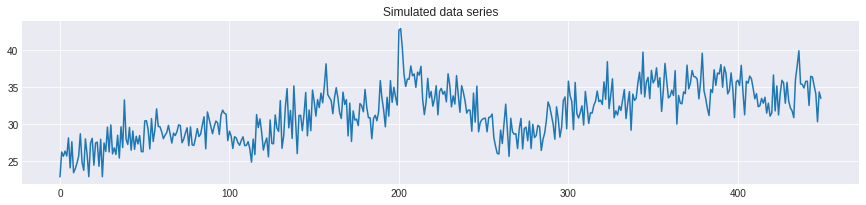

In [9]:
rcParams['figure.figsize'] = 15,3
plt.plot(data.sales_ad)
plt.title('Simulated data series')
plt.show()

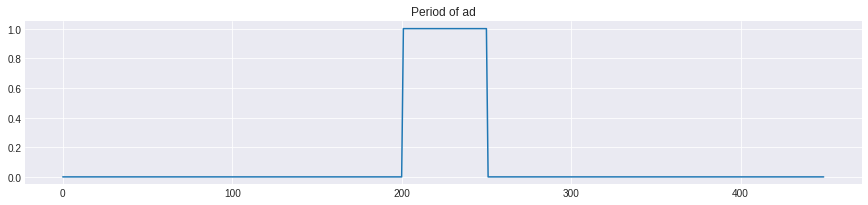

In [10]:
rcParams['figure.figsize'] = 15,3
plt.plot(data.dummy_ad)
plt.title('Period of ad')
plt.show()

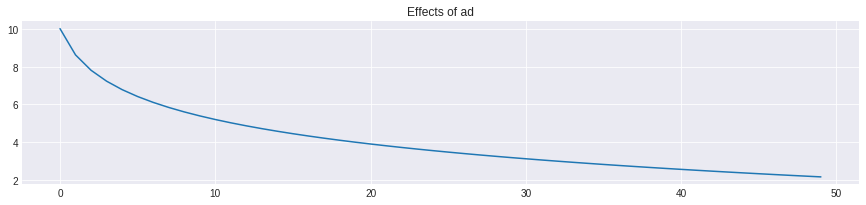

In [11]:
rcParams['figure.figsize'] = 15,3
plt.plot(true_reg_coef)
plt.title('Effects of ad')
plt.show()

#モデリング

状態空間モデルのローカルレベルモデルに、広告効果に関する時変の説明変数を付け加えたもの。（もっといいモデリング方法があれば教えてください！）

$$
\begin{align}
  \mu_t &= \mu_{t-1} + w_t &w_t \sim Normal(0,\sigma^2_w)  \\
  y_t &= \mu_t + a_t*dummy\_ad+v_t &v_t \sim Normal(0,\sigma^2_v) 
\end{align}
$$
<br>
これを別の書き方にすると、
<br>
$$
\begin{align}
  \mu_t &\sim Normal(\mu_{t-1},\sigma^2_w)  \\
  y_t &\sim  Normal(\mu_t +  a_t*dummy\_ad+v_t +v_t,\sigma^2_v) 
\end{align}
$$


##Stanの実装

Stanの式は次のとおり。なお、Stanでは事前分布を指定しないと自動的に制限された範囲内で十分に幅の広い一様分布が使われるようです。

In [0]:
Effect_ad_model = '''
data{
    int<lower=0> N;
    real<lower=0> sales_ad[N];
    real<lower=0, upper=1> dummy_ad[N];
}

parameters{
    real mu_zero;
    real mu[N];
    real<lower=0> sigma_w;
    real<lower=0> sigma_v;
    real a[N];
}

model{
    mu[1] ~ normal(mu_zero, sqrt(sigma_w));
    
    for(i in 2:N){
      mu[i] ~ normal(mu[i-1], sqrt(sigma_w));
    }
    
    for(i in 1:N){
      sales_ad[i] ~ normal(mu[i] + a[i]*dummy_ad[i], sqrt(sigma_v));
    }
}
'''

上記のstanファイルを直接読み込んでもいいのですが、コンパイルと乱数発生を別にして、乱数発生を色々試したかったので、外からstanファイルを読み込むことにします。

In [53]:
from google.colab import files
uploaded = files.upload()

Saving Effect_ad_model.stan to Effect_ad_model (1).stan


まずはstanファイルのコンパイル。

In [49]:
stanmodel = pystan.StanModel(file='Effect_ad_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f35367349717199a1e7e29d1b7953b86 NOW.


データをstanに優しい形式にして、実行。

In [50]:
data_stan = dict(N=N, sales_ad=data.sales_ad, dummy_ad=data.dummy_ad)
fit = stanmodel.sampling(data=data_stan, iter=2000, chains=4, seed=1, n_jobs=-1)

#推定結果の解釈

1行目はモデルのファイル名<br>
2行目にはMCMCのchain数、iterationのステップ数、warmupのステップ数、thinningのステップ数が表示。今回はデフォルトの設定。MCMCのサンプルの長さは<br><br>
$$
  \frac{chains*(iterations - warmup)}{thinning}
$$
<br>
になるので、今回は4000となります。

meanはMCMCのサンプルの平均値で事後平均。se_meanはmeanの標準誤差。sdは標準偏差。2.5%～97.5%はそれぞれの分位点。n_effはStanが自己相関等あkら判断した実効的なMCMCサンプル数。著者によると100くらいが望ましいです。RhatはMCMCの収束の判断のひとつ。1.1以下だと収束とみなせます。<br>
が、広告効果の変数のゼロの収まりが悪いですね…。というか、これは効果なしというゼロに収束？したという見方でいいのでしょうか？

In [51]:
print(fit)

Inference for Stan model: anon_model_f35367349717199a1e7e29d1b7953b86.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_zero  25.27    0.02   1.01  23.24  24.62  25.28  25.95  27.19   3897    1.0
mu[1]    25.26    0.01   0.88  23.49   24.7  25.27  25.84   27.0   3997    1.0
mu[2]    25.42    0.01   0.79  23.85  24.89  25.43  25.94  26.95   4014    1.0
mu[3]    25.51    0.01   0.74  24.01   25.0  25.52  26.02  26.92   3627    1.0
mu[4]     25.6    0.01   0.71  24.18  25.11   25.6  26.08  26.99   4217    1.0
mu[5]    25.64    0.01   0.69  24.33  25.19  25.65   26.1   27.0   4184    1.0
mu[6]    25.69    0.01   0.66  24.41  25.23   25.7  26.13  26.98   3933    1.0
mu[7]    25.59    0.01   0.65  24.32  25.15  25.59  26.02  26.87   3995    1.0
mu[8]    25.59    0.01   0.65  24.29  25.15  25.59  26.02  26.88   4024    1.0
mu[9]    25.45    0.0

##Traceplot

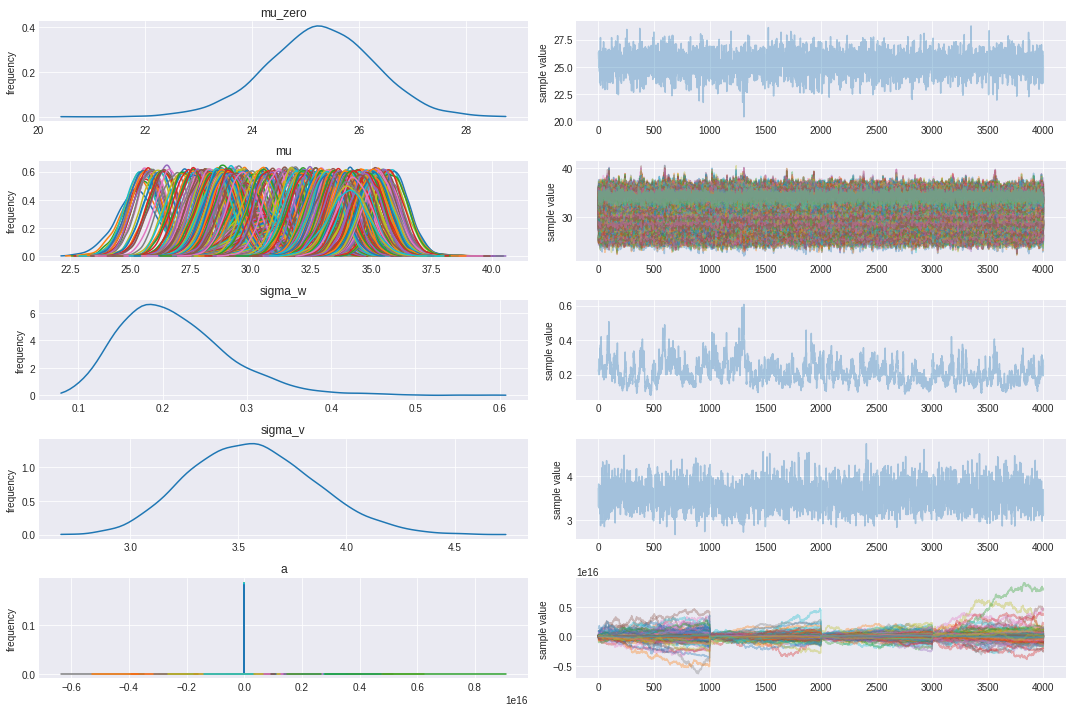

In [54]:
rcParams['figure.figsize'] = 15, 10
fit.plot()
plt.tight_layout()
plt.show()

#図示

##トレンドの図示


###事後平均

In [0]:
#結果を抽出
ms = fit.extract() 

#muの事後平均を算出
mu_mean = ms['mu'].mean(axis=0)

#広告効果の回帰係数の事後平均を算出
a_mean = ms['a'].mean(axis=0)
#Rhatが収束していないものをゼロに
a_mean[:201] = 0
a_mean[251:] = 0

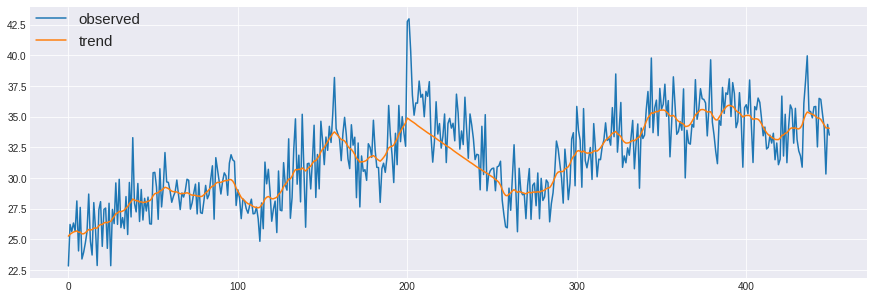

In [131]:
rcParams['figure.figsize'] = 15, 5

plt.plot(data.sales_ad, label='observed')
plt.plot(mu_mean, label='trend')
plt.legend(loc='upper left', borderaxespad=0, fontsize=15)

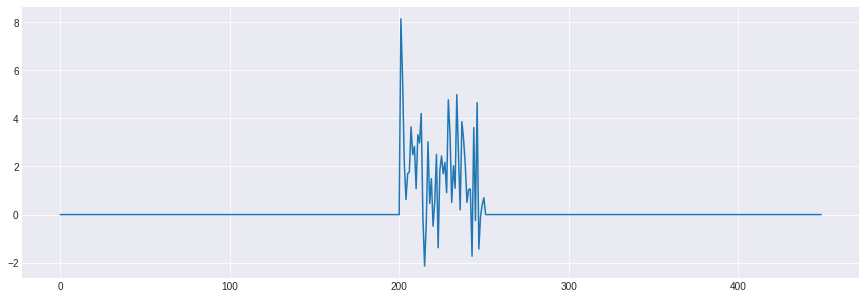

In [132]:
plt.plot(a_mean)

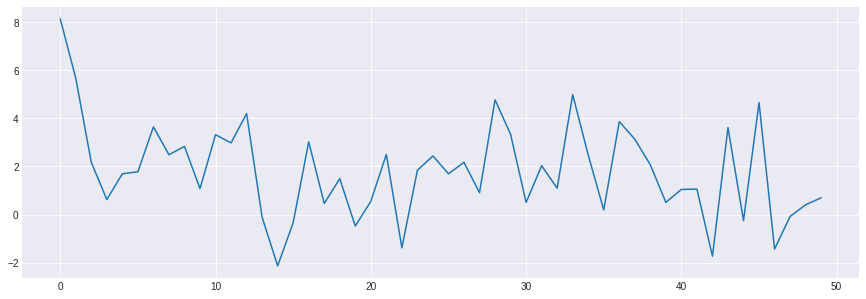

In [133]:
#該当部分のみ拡大
plt.plot(a_mean[201:251])

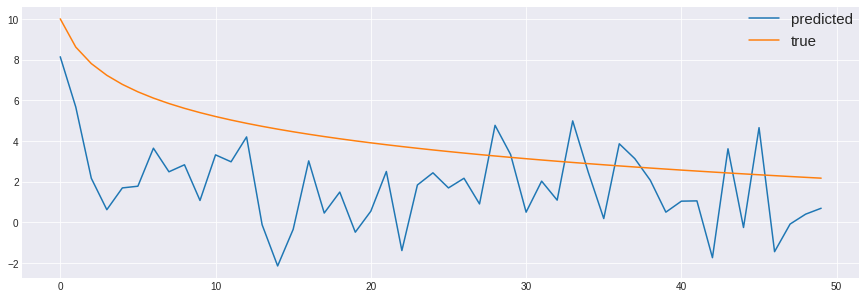

In [134]:
#真の係数と比較
plt.plot(a_mean[201:251], label='predicted')
plt.plot(true_reg_coef, label='true')
plt.legend(loc='upper right', borderaxespad=0, fontsize=15)

何となく右肩下がりは示せているのでしょうか…？

###事後中央値

In [0]:
#muの事後中央値を算出
mu_median = pd.DataFrame(ms['mu']).apply(lambda x: np.percentile(x, 50), axis=0)

#広告効果の回帰係数の事後中央値を算出
a_median = pd.DataFrame(ms['a']).apply(lambda x: np.percentile(x, 50), axis=0)
#Rhatが収束していないものをゼロに
a_median.iloc[:201] = 0
a_median.iloc[251:] = 0

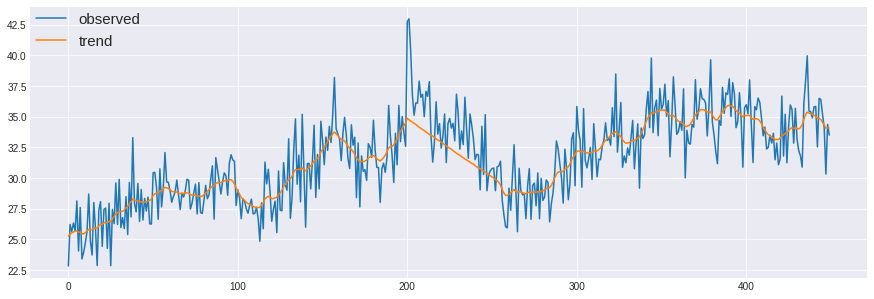

In [136]:
rcParams['figure.figsize'] = 15, 5

plt.plot(data.sales_ad, label='observed')
plt.plot(mu_median, label='trend')
plt.legend(loc='upper left', borderaxespad=0, fontsize=15)

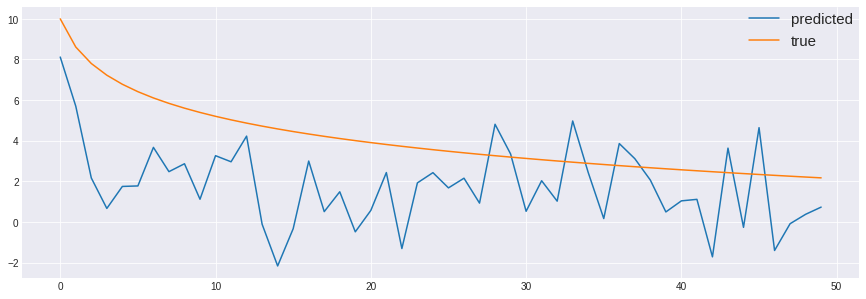

In [137]:
#真の係数と比較
plt.plot(np.array(a_median.iloc[201:251]), label='predicted')
plt.plot(true_reg_coef, label='true')
plt.legend(loc='upper right', borderaxespad=0, fontsize=15)